# Clustering

Clustering is a technique that groups together data points based on their similarities. In light of the data science workflow discussed before {numref}`ch_workflow` clustering can be used as a data exploration tool as well as to model our data. In this section, we will explore different clustering algorithms, including KMeans and DBSCAN, and apply them to synthetic datasets. We will discuss how clustering algorithms work and what their different advantages and limitations are.

## What is clustering?
Clustering refers to the process of searching for a "natural" or useful divide of data points into a number of groups or: clusters. There is a commonly shared intuition that a "good" cluster is one where all datapoints have high similarity or share some important properties. In same cases, this can indeed be simple in the sense that most people would intuitively agree on a suitable division into clusters, such as illustrated in {numref}`fig_clustering_intro`. At least, I haven't yet had a student that gave an answer that was different from "three" when asked for the number of groups in this dataset. In practice, however, those question will not be answered by any of my students, nor by me. We will use a range of different **clustering algorithms** to do the clustering for us.


```{figure} ../images/fig_clustering_intro.png
:name: fig_clustering_intro

Clustering refers to dividing data points into seperate groups or: clusters. 
```

Next, we create such a synthetic dataset with three clusters. This dataset consists of three groups of points, each generated from a different Gaussian distribution. Each group of points has its own mean and standard deviation along the x and y axes.

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# optional, only to avoid KMeans warning on Windows (too few chunks compared to threads)
import os
os.environ["OMP_NUM_THREADS"] = "2"

In [6]:
clusters = [(15, 0.5, 0.5, 1.5, -0.7),
           (21, 0.8, 0.5, -2.1, -1.2),
           (25, 0.8, 0.7, -2.6, 2.3)]

np.random.seed(42)
data = np.zeros((0, 2))
for (n_points, x_scale, y_scale, x_offset, y_offset) in clusters:
    xpts = np.random.randn(n_points) * x_scale + x_offset
    ypts = np.random.randn(n_points) * y_scale + y_offset
    data = np.vstack((data, np.vstack((xpts, ypts)).T))

We visualize the dataset using pyplot. The dataset contains three visually distinct clusters.

(-5.045066207823071,
 2.6388765323049705,
 -2.0892219515793373,
 4.315388118278701)

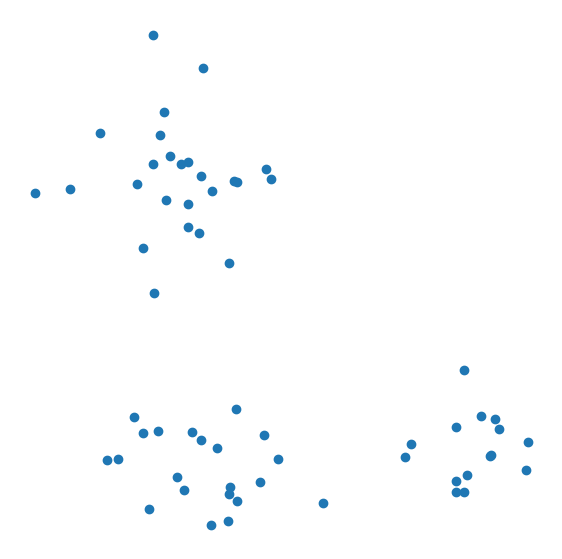

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1])
plt.axis('off')
plt.show()

Assigning the three clusters in this case does not exactly feel like rocket science. We could all do this manually with a pen in no time. So, why bother to use - let alone understand or develop - algorithms for this task?

There are two reasons for why the shown figure makes the task look easy. First, the points are distributed in a way that immediately suggests clear boundarys or center positions. And everyone knows that not all cases will look that simple. More importantly, however, is the fact that in most cases our datapoints will be nothing we can simply "look" at, or draw lines around, because the data won't be 2-dimensional. Instead datpoints might have any number of features, which is exactly what I mean here with *dimensions*. And in 4D, 5D, 6D, 10D, 100D, there is no chance to manually assign clusters to datapoints.

In addition, there are even more reasons to rather search for a good algorithm than to assign clusters manually. Algorithms allow to cluster much larger datasets. And, in some cases, they will give consistent, reproducible results, i.e., they will assign each element the same cluster whenever we run the algorithm again. We will later see, that this is not true for all clustering algorithms.

#### Why do we want to cluster data?

Clustering data serves as a fundamental technique in the data scientist's toolkit for a myriad of reasons beyond the mere convenience of handling multidimensional data. One significant motive is the discovery of intrinsic patterns and structures within the data that are not apparent through simple observation, especially when dealing with high-dimensional datasets. These hidden patterns can unveil relationships, categories, and subclasses within the data that can lead to valuable insights and, ultimately, inform decision-making processes.

Moreover, clustering enables us to summarize a vast amount of data through the formation of representative groups or clusters. This is not only efficient for data compression but also crucial for simplifying complex data for further analysis, visualization, and reporting. When we group similar data points together, we can study these groups' characteristics to understand the underlying population better. For instance, in customer segmentation, clustering helps in identifying groups with common behaviors, leading to targeted marketing strategies.

Another compelling reason to employ clustering is anomaly detection. By understanding what is 'normal' for a given cluster, it becomes easier to spot outliers or anomalies that may signify errors, fraud, or new, previously undocumented phenomena. This is particularly relevant in fields such as cybersecurity, where clustering can help in identifying unusual patterns that may indicate security breaches.

Lastly, clustering can serve as a pre-processing step for other algorithms. By organizing data into clusters, we can run other algorithms more efficiently within each cluster, reducing computational costs and improving algorithm performance. This layered approach can be seen in complex tasks such as image and speech recognition, where initial clustering can significantly streamline subsequent analysis.

In summary, clustering is not just a convenience but a powerful method for uncovering and leveraging the rich, multi-dimensional structures in data, which in turn can lead to more effective and informed decision-making across diverse domains.

**Hard and Soft Clustering**

In most cases, **clustering** refers to the process of assigning at most **one** cluster to each data point. It is hence a binary decision that needs to be made, either manually, or -and that is what we are interested in here- in an automated way. It is also possible to allow clusters to overlap such that elements can belong to more than one cluster. This is then called *soft clustering* as displayed in {numref}`fig_clustering_hard_soft`. Most commonly, and in this introductory book as well, the term clustering primarily refers to *hard clustering*.

```{figure} ../images/fig_clustering_hard_soft.png
:name: fig_clustering_hard_soft

Two conceptually differnt types of clustering are *hard clustering* in which elements can only be part of one cluster (or none), and *soft clustering* which allows elements to be in more than one cluster. Unless specified otherwise, clustering usually refers to *hard clustering*. 
```

### Mini-exercise
Team up with your neighbor (if in a class), or try on your own. Looking at the data displayed in {numref}`fig_clustering_intro`, how would you write an algorithm to automatically assign each datapoint a cluster it belongs to?

---

### What did you come up with?
When I ask this to students, I typically get many different answers. Including many suggestions that are very likely to work for the displayed example. One way to go is to look at distances between points and somehow define how far points are allowed to be before they no longer fall into the same cluster. Other approaches might include fitting lines, borders, shapes into the scatter datapoints. But there are many more options one could come up with. It is therefore no big surprise, that many different clustering algorithms exist.

## KMeans Clustering

The K-means algorithm is often likened to the task of organizing similar items into buckets. To understand how it works in an accessible way, let’s envision we are sorting fruit based on sweetness and size. Each fruit will be a data point with sweetness and size as its two features.

Here’s the step-by-step process:

1. **Initialization**: First, we decide on the number of buckets (clusters) we want – let’s say three for our fruit example. We randomly pick three fruits and declare each as the 'representative' or centroid of a bucket.
2. **Assignment**: Each piece of fruit is then assigned to the closest bucket's representative based on its sweetness and size. 'Closest' here means the representative that has the most similar sweetness and size to the fruit we’re trying to sort.
3. **Update Centroids**: After all fruits are assigned, each bucket's representative is updated to be the 'average' fruit of that bucket, considering the sweetness and size of all fruits in the bucket. This new 'average' fruit becomes the new centroid.
4. **Repeat Assignment and Update**: Steps 2 and 3 are repeated. Fruits may switch buckets if they’re closer to a different centroid after the update. New centroids are calculated after the reassignments.
5. **Convergence**: This process of assignment and updating continues until things settle down – that is, the fruits no longer switch buckets (clusters), and the centroids no longer change. This is called convergence.
6. **Result**: At the end, we have our fruits sorted into buckets where each fruit is surrounded by others with similar sweetness and size. Each bucket represents a cluster.

In a more technical context, the 'sweetness' and 'size' are analogs for the features of the dataset, and the 'average' fruit represents the mean of the cluster's points in feature space.

The algorithm repeatedly performs two straightforward steps: assigning points to the nearest centroid and then updating those centroids. This simplicity, however, comes with the drawbacks mentioned, such as having to pre-specify the number of clusters and its sensitivity to the initial placement of centroids, among others.

```{figure} ../images/fig_kmeans_sketch.png
:name: fig_kmeans

Sketch of k-means algorithm...
```

**Pros:**

- Simple and easy to understand
- Efficient in terms of computational complexity
- Works well with isotropic clusters

**Cons:**

- Requires the user to specify the number of clusters
- Assumes equal-sized clusters
- Sensitive to initial conditions and may converge to a local minimum
- Does not consider outliers

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(data)

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


We visualize the resulting clustering. Each cluster is shown with a different color.

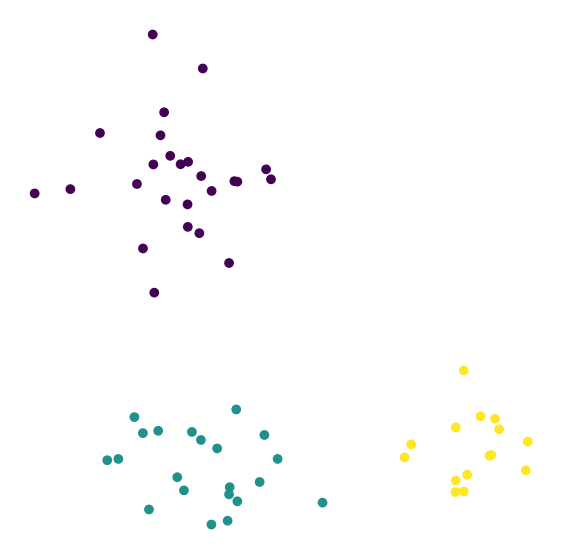

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=kmeans.labels_)

plt.axis("off")
#plt.savefig("example_clustering_00_clusters.png", dpi=300)
plt.show()

### Very often, clusters are not that easily distinguishable!
In the following code blocks we create a new synthetic dataset with five clusters, and visualize it.
This is already one step more "realistic" in the sense that most commonly we do not deal with ideally distinctive clusters an shown in the examples above. Very often is is not so clear where a cluster begins and where one ends, nor how many clusters we actually have. 

In [10]:
clusters = [(61, 1, 1.5, 2.5, -0.7),
           (37, 0.8, 0.5, 1.1, -1.2),
           (49, 1.1, 1.2, -2.6, 2.3),
           (44, 0.45, 0.4, 0.5, 2.3),
           (70, 0.9, 0.3, -2.5, -1.7)]

np.random.seed(1)
data = np.zeros((0, 2))
for (n_points, x_scale, y_scale, x_offset, y_offset) in clusters:
    xpts = np.random.randn(n_points) * x_scale + x_offset
    ypts = np.random.randn(n_points) * y_scale + y_offset
    data = np.vstack((data, np.vstack((xpts, ypts)).T))

In [11]:
data.shape

(261, 2)

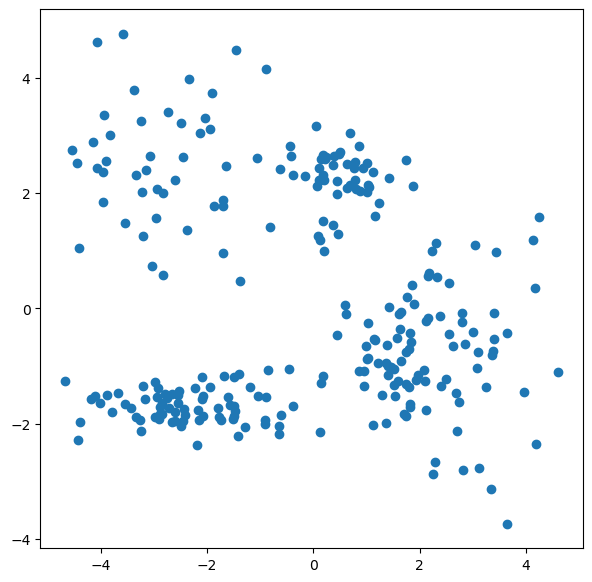

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1])
# plt.savefig("example_clustering_01.png", dpi=300, bbox_inches="tight")

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(data)
kmeans.labels_

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([3, 3, 2, 2, 3, 0, 3, 0, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 3,
       3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3,
       3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 0, 4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4,
       4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
kmeans.cluster_centers_

array([[ 0.42175481,  2.27101038],
       [-2.34187934, -1.65931661],
       [ 1.6215401 , -1.2506384 ],
       [ 2.96607164, -0.10142692],
       [-2.99127157,  2.52658441]])

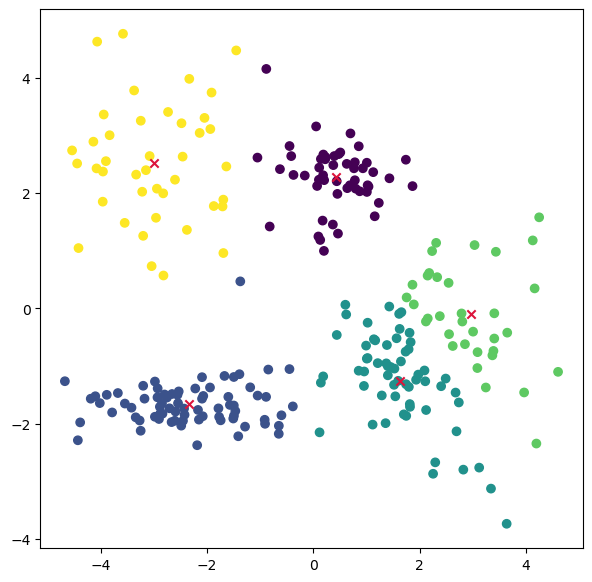

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=kmeans.labels_)
ax.scatter(kmeans.cluster_centers_[:, 0],
          kmeans.cluster_centers_[:, 1], marker="x", color="crimson")

#plt.savefig("example_clustering_01_kmeans.png", dpi=300, bbox_inches="tight")

In [16]:
kmeans.predict([[-2, 0], [4, 3]])

array([1, 3])

In [17]:
kmeans.cluster_centers_

array([[ 0.42175481,  2.27101038],
       [-2.34187934, -1.65931661],
       [ 1.6215401 , -1.2506384 ],
       [ 2.96607164, -0.10142692],
       [-2.99127157,  2.52658441]])

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It's like an adventurous hike where we group together hikers based on how closely they walk together and how often they stop to rest. To explain DBSCAN in an accessible way, let's consider our hikers as data points in a park (our dataset).

Here’s how DBSCAN works:

1. **Starting Point (Core Points)**: We start by picking a hiker and checking around them to see how many other hikers are within a certain distance, which we'll call 'epsilon'. If there are enough hikers (meeting a minimum number, `min_samples`) within this distance, we consider this a 'core' group, much like a core point in DBSCAN.
2. **Forming Groups (Cluster Expansion)**: From our core hiker, we extend the group by asking each new hiker in the epsilon area to invite other hikers within their own epsilon area. If these hikers also have enough companions within their reach, the group grows – this is how DBSCAN expands clusters.
3. **Connecting Groups (Density Reachability)**: Sometimes, a hiker might not have enough people within their epsilon distance to form their own core group but is close enough to be part of the existing group. These hikers act as bridges and help in joining different core groups, forming a larger cluster.
4. **Identifying Lone Hikers (Noise Detection)**: Not everyone wants to walk in groups. Hikers who don't have enough nearby companions and aren't close enough to a group are considered 'noise'. In data terms, these are outliers.
5. **Adapting to Terrain (Handling Different Densities)**: Just as groups of hikers might spread out in open fields and bunch up in narrow trails, DBSCAN tries to adapt to areas of different point densities. This can be tricky because the same 'epsilon' and `min_samples` might not work for both sparse and dense areas, which is a challenge for DBSCAN.
6. **Exploring the Entire Park (Full Dataset)**: The process continues until all hikers are either grouped or labeled as noise. Unlike K-means, we don’t need to know how many groups (clusters) we want to form in advance – the hikers (data points) naturally form groups based on their proximity and the number of companions they have.

The DBSCAN algorithm's capacity to identify outliers and form clusters  of arbitrary shapes makes it versatile and powerful, particularly for  complex datasets where patterns aren’t obvious. However, choosing the  right epsilon and `min_samples` is crucial, as these parameters will greatly influence the clustering outcome.

**Pros:**

- Does not require the user to specify the number of clusters
- Can identify clusters with arbitrary shapes
- Robust to noise
- Can identify outliers (as "noise")

**Cons:**

- May struggle with clusters of varying densities
- The choice of hyperparameters (epsilon and min_samples) can significantly affect the results

In [18]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=2).fit(data)

In [19]:
dbscan.labels_

array([ 0,  1,  1,  1,  1,  2,  0,  3,  4,  5, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  4,  1,
        1,  1,  1,  5,  1,  4,  6,  1,  1,  1,  1,  1,  7,  1,  1,  1,  8,
        1,  1,  1, -1,  1,  1,  1,  1,  8,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  7,  1,  1,  1,  1,  1,  1,  1,  9,  9, 10, -1,
       11, 10, 12,  7, -1, 13, -1, -1, 13,  3, 12, 13, -1, -1, -1, -1,  9,
       12,  3, 12, -1,  9, -1,  9, 13,  2, 12, 11, -1, 12,  9, -1, 10,  3,
        9, 13, 13, 12, 13, -1, 12, 12, 12, 13, 12,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3, -1,  3,
        3,  3,  3,  3,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7, -1,  7,  7

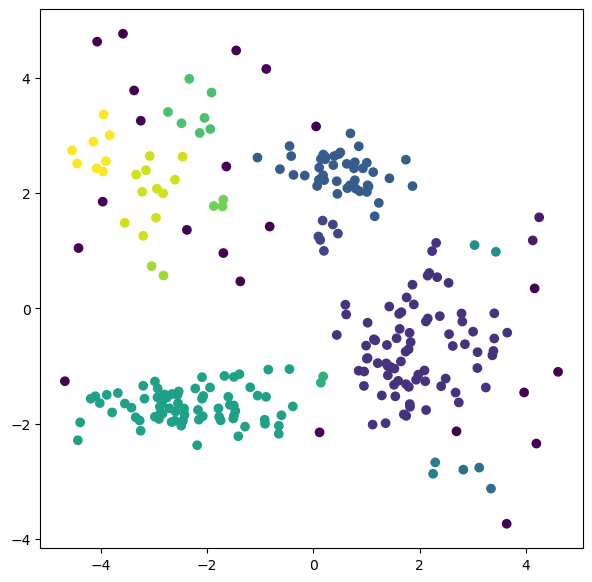

In [20]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=dbscan.labels_)

plt.savefig("example_clustering_01_dbscan_eps_05.png", dpi=300,
           bbox_inches="tight")

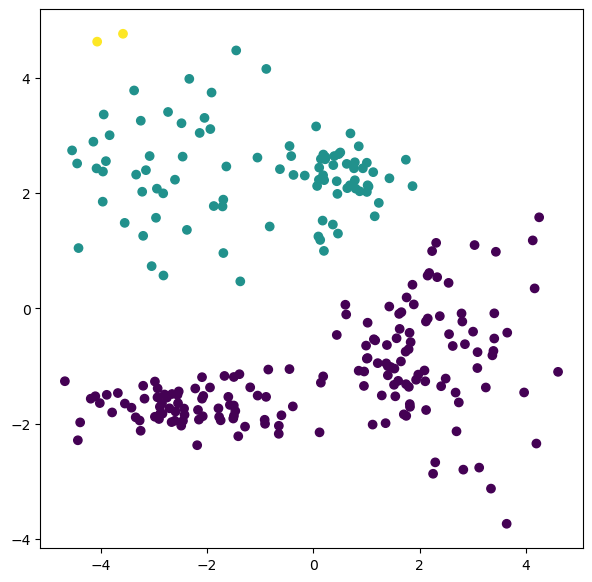

In [21]:
dbscan = DBSCAN(eps=1, min_samples=2).fit(data)

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=dbscan.labels_)

# plt.savefig("example_clustering_01_dbscan_eps_1.png", dpi=300, bbox_inches="tight")

## Gaussian mixture models
Gaussian Mixture Models (GMM) can be thought of as a sophisticated extension of the K-means clustering technique, with added flexibility. If we were to visualize data clustering as a process of sorting different types of coins based on their size and weight, K-means would sort them into predefined buckets, while GMM would be like having scales and calipers that tell us not just which bucket a coin most likely belongs to, but also provide a measure of our certainty about it.

Here's a breakdown of how GMM works:

1. **Assumptions**: GMM starts with the assumption that our data points are generated from a mixture of several Gaussian distributions. Each Gaussian, also known as a normal distribution, represents a cluster. It’s like assuming that coins come from different countries, each with its unique size and weight characteristics.
2. **Expectation-Maximization (EM) Steps**:
   - **Expectation (E-step)**: Here, the algorithm assesses each data point and estimates the probabilities of it belonging to each of the Gaussian distributions (clusters). In our coin analogy, this is like guessing the origin of a coin based on its size and weight, but instead of being certain, we assign probabilities to the likelihood of it coming from each country.
   - **Maximization (M-step)**: Based on these probabilities, GMM updates the parameters of the Gaussian distributions—namely, the means (which are like the centroid in K-means), the variances (which tell us how spread out each cluster is), and the mixture weights (which tell us how large or small each cluster is compared to others). This is akin to adjusting our scale and calipers based on all the coins we've measured to better fit the actual data.
3. **Iterative Process**: These two steps are repeated iteratively, with each pass refining the parameters and improving the model's accuracy in representing the underlying clusters.
4. **Soft Clustering**: Unlike K-means, which assigns each point to a single cluster, GMM provides a probability distribution over the clusters for each point, indicating its degree of membership in every cluster. This soft assignment is particularly useful when we’re not sure about the boundaries of clusters, much like a coin that’s in between typical sizes and weights for known designs.
5. **Final Model**: After several iterations, when the changes in the parameters become negligible, the algorithm has hopefully converged to the best fit for our data, and we have a final model that tells us not only where the clusters are, but also how certain we can be about each data point's membership.

**Pros:**

- More flexible than K-means and can model clusters with different shapes, sizes, and orientations
- Provides a soft clustering, assigning probabilities of each point belonging to each cluster

**Cons:**

- Requires the user to specify the number of clusters
- Computationally more expensive than K-means
- Requires a high enough number of datapoints to fit the gaussians

In [22]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=5, random_state=0).fit(data)

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [23]:
gm.means_

array([[ 0.52999396,  2.351833  ],
       [-2.24768005, -1.68397941],
       [ 1.52656097, -1.03882914],
       [ 2.60181439, -0.35911277],
       [-2.79891712,  2.49297901]])

In [24]:
labels = gm.predict(data)

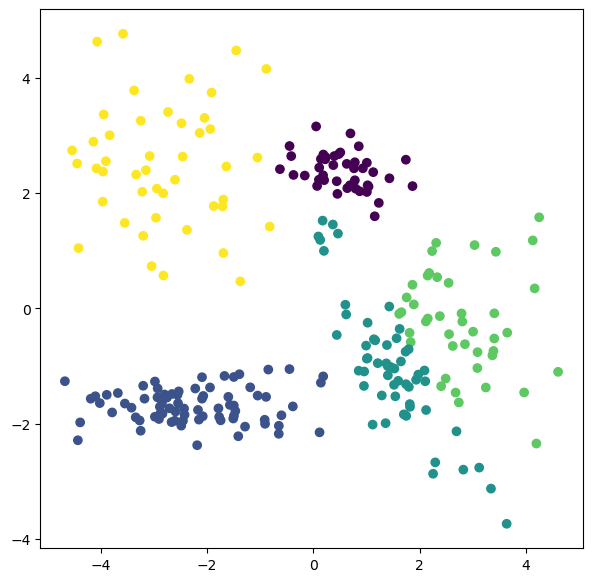

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=labels)
# plt.savefig("example_clustering_01_gaussian_mixture.png", dpi=300, bbox_inches="tight")

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


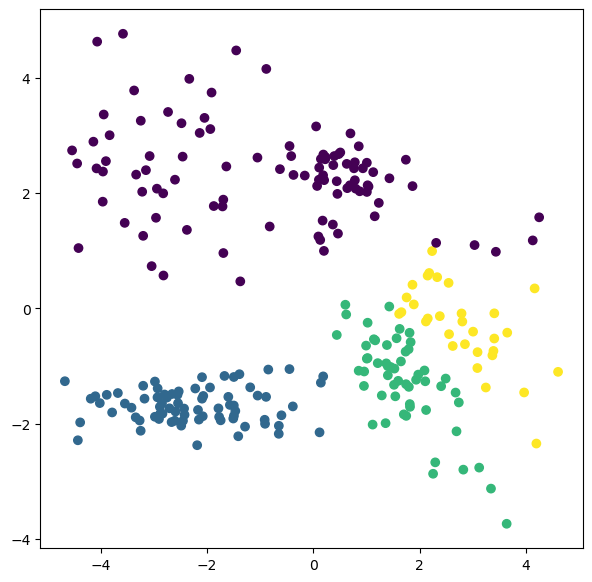

In [26]:
gm = GaussianMixture(n_components=4, random_state=0).fit(data)
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=gm.predict(data))
# plt.savefig("example_clustering_01_gaussian_mixture_c4.png", dpi=300, bbox_inches="tight")

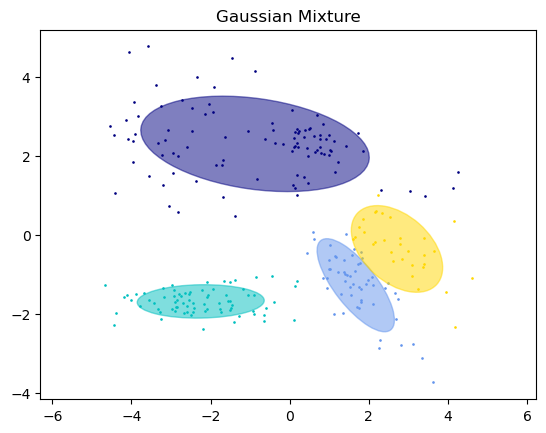

In [27]:
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html
import itertools
from scipy import linalg
import matplotlib as mpl

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1],
                                  angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-9.0, 5.0)
    #plt.ylim(-3.0, 6.0)
    plt.axis("equal")
    plt.title(title)

plot_results(data, gm.predict(data),
             gm.means_, gm.covariances_, 0, "Gaussian Mixture")


## Hierarchical clustering (Ward)
Hierarchical clustering, particularly the Ward method, operates much like a family tree of data points, showing the relationships between different clusters from the ground up. To visualize hierarchical clustering in an everyday context, imagine a scenario where we’re trying to organize a large collection of books on a set of shelves.

Here's the process outlined in a more accessible manner:

1. **Starting with Every Book (Initialization)**: Initially, each book is considered its own 'cluster'. This is the bottom-up approach where every single item starts in its own group.
2. **Creating Shelves (Agglomeration)**: We begin to organize the books by placing the most similar ones together on a shelf. In the context of hierarchical clustering, similarity is usually based on the distance between data points. The Ward method specifically looks to minimize the variance within a cluster, which is like trying to put books of similar sizes or genres together to make the shelf look neat (minimize variance).
3. **Building Sections (Building the Hierarchy)**: Each time we place a pair of books together, we're building a small section of our shelf. As we continue this process, we start to see not just individual books or pairs but groups and subgroups forming, each representing a branch in our tree of book categories.
4. **Forming a Library (Creating the Dendrogram)**: We don’t just stop once we’ve created a few shelves; we continue until all books are grouped in a way that shows their relationships, from the individual books up to the entire genre sections. In clustering terms, this is akin to building a dendrogram—a tree-like diagram that records the sequences of merges or splits.
5. **Deciding on Genres (Determining the Number of Clusters)**: The beauty of hierarchical clustering is that we don’t need to decide how many genres (clusters) we want at the start. Once our dendrogram is complete, we can cut it at the level that makes sense to us, which might be broad genres or more specific sub-genres, depending on our needs.

The pros of this method are that it doesn’t require us to predefine the number of clusters, and it gives us a visual representation of the data's hierarchy, which can be incredibly insightful. However, this method can be demanding in terms of computation, especially with large datasets—it's like trying to organize a library by hand. Furthermore, because it uses an agglomerative approach, decisions made early on cannot be undone without starting over, which can sometimes lead to less optimal clustering. Also, while we don't need to specify the number of clusters upfront, we still need a criterion to decide where to 'cut' the dendrogram to define our clusters.

**Pros:**

- Does not require the user to specify the number of clusters beforehand (can be chosen by analyzing the dendrogram)
- Provides a hierarchical representation of the data, which can be useful for understanding the relationships between clusters

**Cons:**

- Computationally more expensive than K-means and DBSCAN, especially for large datasets
- Assumes that the distance between clusters can be represented by the within-cluster variance
- Requires number of clusters OR distance threshold

In [28]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(linkage="ward",
                              n_clusters=None,
                              distance_threshold=10.0).fit(data)

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


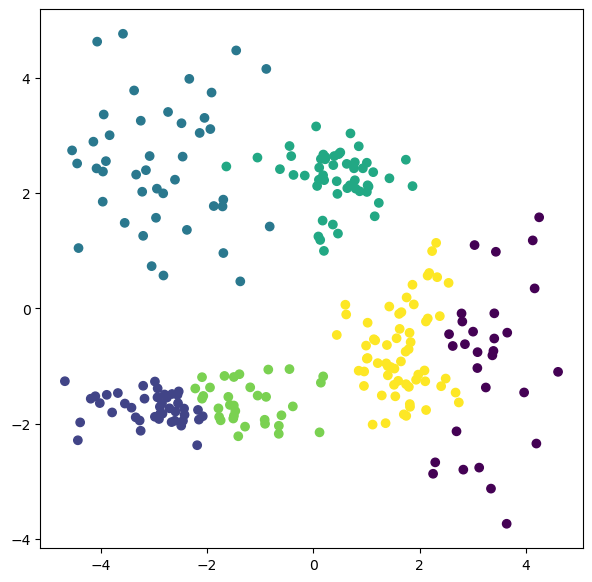

In [29]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=ward.labels_)
# plt.savefig("example_clustering_01_hierarchical_ward.png", dpi=300, bbox_inches="tight")

In [30]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(linkage="ward",
                              n_clusters=None,
                              distance_threshold=2.0).fit(data)

C:\Users\flori\anaconda3\envs\ai_smart_health\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


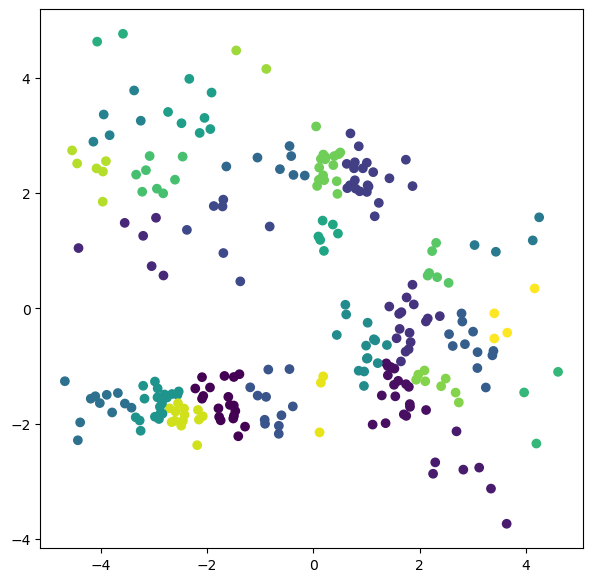

In [31]:
gm = GaussianMixture(n_components=4, random_state=0).fit(data)
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(data[:,0], data[:,1], c=ward.labels_)
#plt.savefig("example_clustering_01_hierarchical_ward_dist2.png", dpi=300, bbox_inches="tight")

## Comparison and Conclusion

In this section, we have explored four different clustering algorithms: K-means, DBSCAN, Gaussian Mixture Model (GMM) and hierarchical clustering. Each of these algorithms has its own advantages and disadvantages.

**K-means** is a simple and easy-to-understand algorithm that works well with isotropic clusters. However, it requires the user to specify the number of clusters beforehand and assumes equal-sized clusters. K-means is also sensitive to initial conditions and may converge to a local minimum.

**DBSCAN** does not require the user to specify the number of clusters and can identify clusters with arbitrary shapes. It is also robust to noise. However, DBSCAN may struggle with clusters of varying densities, and the choice of hyperparameters (epsilon and min_samples) can significantly affect the results.

The **Gaussian Mixture Model** (GMM) is a generative probabilistic model that assumes each cluster is generated from a Gaussian distribution. GMM is more flexible than K-means and can model clusters with different shapes, sizes, and orientations. However, GMM requires the user to specify the number of clusters and is computationally more expensive.

**Hierarchical Clustering** builds a hierarchy of clusters, either agglomerative (bottom-up) or divisive (top-down), with the Ward  method being an example that minimizes the within-cluster variance. This method doesn’t require specifying the number of clusters, offering a  visual dendrogram to aid in cluster selection, though it is  computationally expensive for large datasets.

In conclusion, the choice of clustering algorithm depends on the data, the problem, and the desired characteristics of the clustering solution. It is often helpful to try multiple algorithms and compare their results to select the best method for a particular problem.

In [32]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

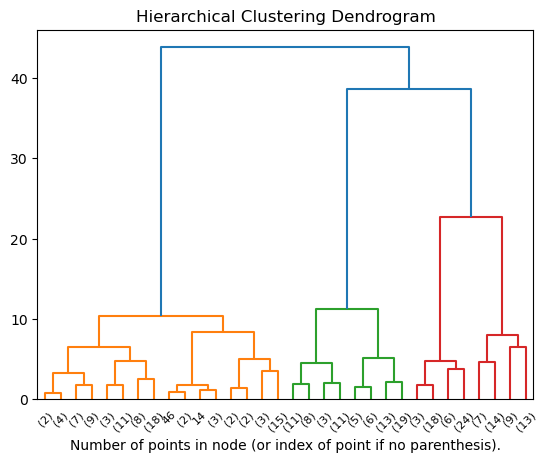

In [33]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ward, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

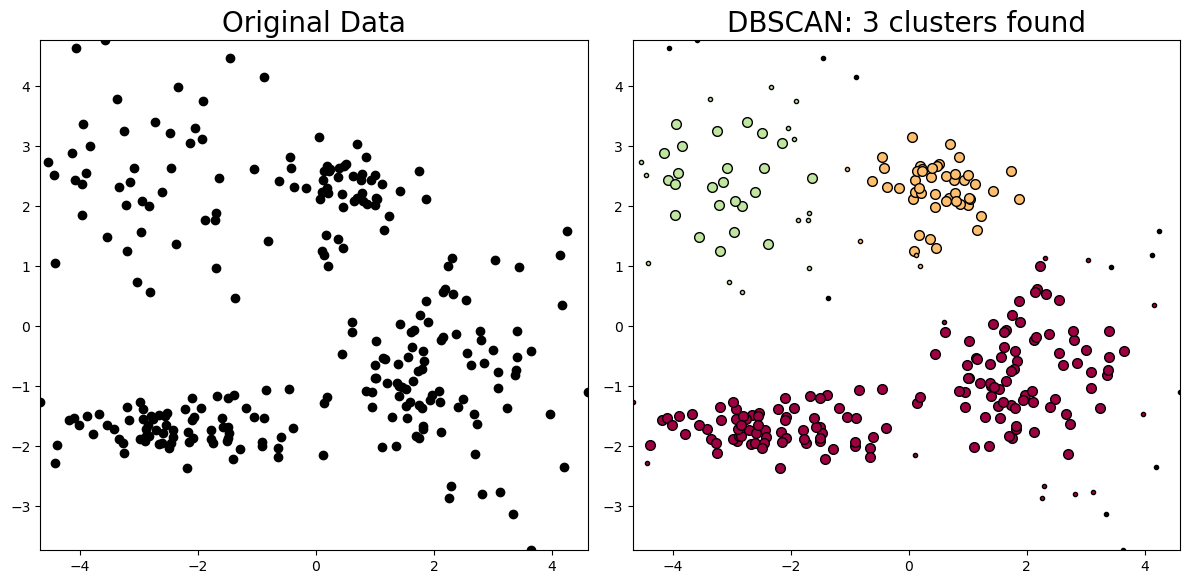

In [34]:
max_distance = 1
db = DBSCAN(eps=max_distance, min_samples=10).fit(data)
# Extract a mask of core cluster members
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Extract labels (-1 is used for outliers)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

# Plot up the results!
min_x = np.min(data[:, 0])
max_x = np.max(data[:, 0])
min_y = np.min(data[:, 1])
max_y = np.max(data[:, 1])

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(data[:,0], data[:,1], 'ko')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Original Data', fontsize = 20)

plt.subplot(122)
# The following is just a fancy way of plotting core, edge and outliers
# Credit to: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('DBSCAN: %d clusters found' % n_clusters, fontsize = 20)
fig.tight_layout()
plt.subplots_adjust(left=0.03, right=0.98, top=0.9, bottom=0.05)